In [2]:
import random
import wandb
from tqdm import tqdm
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import plotly.express as px


import torch

print(torch.__version__)
print(torch.version.cuda)

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Entities
from torch_geometric.nn import GATConv
from torch_geometric.utils import k_hop_subgraph


import collections
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import plotly.express as px

import seaborn as sns
from functools import partial
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


import collections
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

pl.seed_everything(11)

2.1.0
None


Seed set to 11


11

## 1.3 Link Prediction

In [ ]:
from torch_geometric.datasets import FB15k_237

ldataset = FB15k_237(root='data/FB15k_237')
ldata = ldataset[0]

In [ ]:
print(f'Number of nodes: {ldata.num_nodes}')
print(f'Number of edges: {ldata.num_edges}')
print(f'Number of classes: {ldataset.num_classes}')
print(f'Number of node features: {ldata.num_node_features}')
print(f'Number of edge features: {ldata.num_edge_features}')
print(f'Number of edge types: {len(ldata.edge_type.unique())}')

print(f'Contains isolated nodes: {ldata.has_isolated_nodes()}')
print(f'Contains self-loops: {ldata.has_self_loops()}')
print(f'Is undirected: {ldata.is_undirected()}')

print(f'Average node degree: {(ldata.num_edges) / ldata.num_nodes:.2f}')

Number of nodes: 14541
Number of edges: 272115
Number of classes: 0
Number of node features: 0
Number of edge features: 0
Number of edge types: 237
Contains isolated nodes: True
Contains self-loops: True
Is undirected: False
Average node degree: 18.71


### Baseline

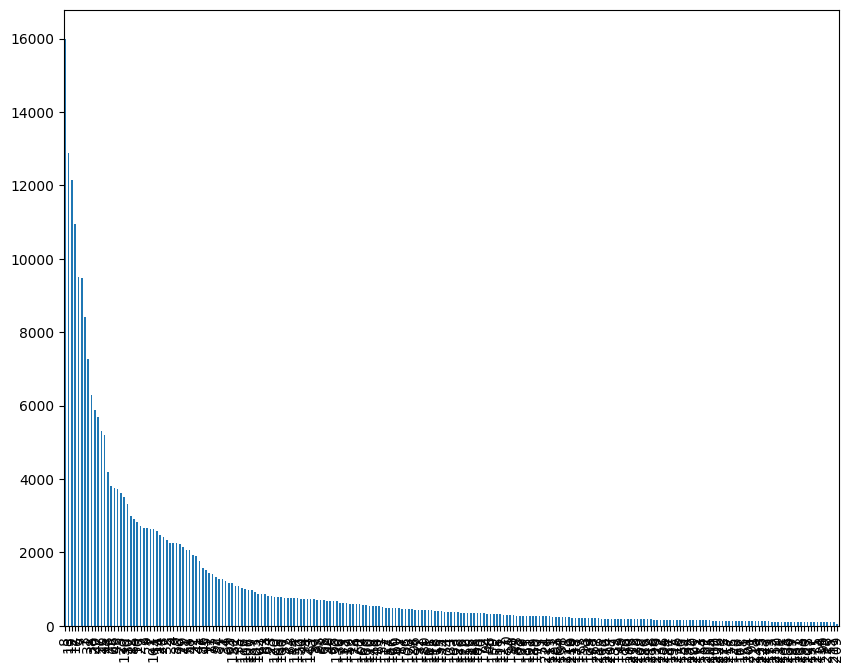

In [ ]:

# Convert tensor to pandas Series
edge_type_counts = pd.Series(ldata.edge_type.numpy()).value_counts()
#sort by frequency
edge_type_counts.sort_values(ascending=False, inplace=True)
edge_type_counts.plot(kind='bar', figsize=(10, 8))


# only keep the top 30 edge types
top_edge_types = edge_type_counts[:30].values.tolist()


src = ldata.edge_index[0].detach().numpy()
dst = ldata.edge_index[1].detach().numpy()
edge_type = ldata.edge_type.detach().numpy()
# map to top edge types
edge_type = np.array([e if e in top_edge_types else -1 for e in edge_type])

lfeatures = np.zeros((ldata.num_nodes, 2 * len(top_edge_types)))

np.add.at(lfeatures, (src, edge_type), 1)
np.add.at(lfeatures, (dst, (edge_type + len(top_edge_types))), 1)

In [ ]:
src = ldata.edge_index[0].detach().numpy()
dst = ldata.edge_index[1].detach().numpy()
edge_type = ldata.edge_type.detach().numpy()

lfeatures = np.zeros((ldata.num_nodes, 2 * ldata.num_edge_types))

np.add.at(lfeatures, (src, edge_type), 1)
np.add.at(lfeatures, (dst, edge_type + ldata.num_edge_types), 1)


In [ ]:
train_data = FB15k_237('data/FB15k_237', split='train')[0]
val_data = FB15k_237('data/FB15k_237', split='val')[0]
test_data = FB15k_237('data/FB15k_237', split='test')[0]

In [ ]:

def get_X_y(data):
    # Get the indices from train_data.edge_index
    src_indices = data.edge_index[0]
    dst_indices = data.edge_index[1]

    # Extract the corresponding pairs of features
    src_features = lfeatures[src_indices]
    dst_features = lfeatures[dst_indices]

    # Concatenate the features together
    X = np.concatenate((src_features, dst_features), axis=1)
    y = data.edge_type

    return X, y

def evaluate_model(model, X, y, top_n):
    # Predict the scores for all edges
    scores = model.decision_function(X)

    # Calculate the reciprocal ranks
    reciprocal_ranks = []
    for i in range(len(y)):
        rank = np.argsort(scores[i])[::-1].tolist().index(y[i].item())
        reciprocal_rank = 1 / (rank + 1)
        reciprocal_ranks.append(reciprocal_rank)

    # Calculate the Mean Reciprocal Rank (MRR)
    mrr = np.mean(reciprocal_ranks)

    # Calculate the Hits at n (H@n)
    hits_at_n = np.mean([1 if y[i].item() in np.argsort(scores[i])[::-1][:top_n] else 0 for i in range(len(y))])


    #hits_at_n = np.mean([1 if y[i] in np.argsort(scores[i])[::-1][:top_n] else 0 for i in range(len(y))])

    return mrr, hits_at_n

def random_ranking():
  ranking = list(range(237))
  np.random.shuffle(ranking)
  return np.array(ranking)


def evaluate_random_model(model, X, y, top_n):
    # create fake scored vector that predicts labels at random


    # Calculate the reciprocal ranks
    reciprocal_ranks = []
    for i in range(len(y)):
        rank = random_ranking().tolist().index(y[i].item())
        reciprocal_rank = 1 / (rank + 1)
        reciprocal_ranks.append(reciprocal_rank)

    # Calculate the Mean Reciprocal Rank (MRR)
    mrr = np.mean(reciprocal_ranks)

    # Calculate the Hits at n (H@n)
    hits_at_n = np.mean([1 if y[i].item() in random_ranking()[::-1][:top_n] else 0 for i in range(len(y))])


    #hits_at_n = np.mean([1 if y[i] in np.argsort(scores[i])[::-1][:top_n] else 0 for i in range(len(y))])

    return mrr, hits_at_n


X_train, y_train = get_X_y(train_data)
X_test, y_test = get_X_y(test_data)

In [ ]:
mrrs= []
hits_at_10s = []
for i in range(3):
  mrr, h_at_10 = evaluate_random_model(clf, X_test, y_test, top_n=10)

  print(f"MRR: {mrr:.4f}")
  print(f"H@10: {h_at_10:.4f}")

  mrrs.append(mrr)
  hits_at_10s.append(h_at_10)


print('mrrs \n')

print((np.mean(mrrs), np.std(mrrs)))
print(mrrs)

print('hits_at_10s \n')

print((np.mean(hits_at_10s), np.std(hits_at_10s)))
print(hits_at_10s)

In [ ]:
import numpy as np
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm


#clf = RandomForestClassifier(max_depth=2, random_state=42)
#clf = lm.LogisticRegression(max_iter=100)
#clf = svm.SVC(decision_function_shape='ovo', random_state=seed)


mrrs= []
hits_at_10s = []
for seed in [42,43,44]:
  clf = lm.LogisticRegression()
  clf.fit(X_train[0:20000,], y_train[0:20000,])
  # done fitting
  print("done fitting")

  mrr, h_at_10 = evaluate_model(clf, X_test, y_test, top_n=10)

  print(f"MRR: {mrr:.4f}")
  print(f"H@10: {h_at_10:.4f}")

  mrrs.append(mrr)
  hits_at_10s.append(h_at_10)


print('mrrs \n \n')

print((np.mean(mrrs), np.std(mrrs)))
print(mrrs)

print('hits_at_10s \n \n')

print((np.mean(hits_at_10s), np.std(hits_at_10s)))
print(hits_at_10s)



### Train GNN

In [ ]:
X_train, y_train = get_X_y(train_data)
X_test, y_test = get_X_y(test_data)

train_data.x = torch.Tensor(X_train)
test_data.x = torch.Tensor(X_test)

In [ ]:
from torch_geometric.nn import TransE

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model = TransE(
    num_nodes=train_data.num_nodes,
    num_relations=train_data.num_edge_types,
    hidden_channels=50,
).to(device)

train_data = train_data.to(device)
test_data = test_data.to(device)
val_data = val_data.to(device)

loader = model.loader(
    head_index=train_data.edge_index[0],
    rel_type=train_data.edge_type,
    tail_index=train_data.edge_index[1],
    batch_size=1024,
    shuffle=True,
)


optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

def train():
    model.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=data.edge_index[0],
        rel_type=data.edge_type,
        tail_index=data.edge_index[1],
        batch_size=20000,
        k=10,
    )

for epoch in range(1, 1500):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
              f'Val Hits@10: {hits:.4f}')


rank, hits_at_10 = test(test_data)
print(f'Test Mean Rank: {rank:.2f}, Test Hits@10: {hits_at_10:.4f}')

### Augmentations